In [1]:
import numpy as np
import time
import math
import random
from numpy import linalg as la
from sparsesvd import sparsesvd
from scipy.sparse.linalg import norm
import scipy.sparse as ss
import scipy.io
import random
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import itertools
% matplotlib inline

## 1. SVT Algorithm
**The referenced paper is 'A Singular Value Thresholding Algorithm for Matrix Completion'.** [It can be acccessed here](https://arxiv.org/pdf/0810.3286.pdf)

In [2]:
"""
 This whole part is only for real number calculations. I didn't implement the complex number part.
 
 M is a random full matrix which we try to recover;
 n1,n2 are the shape of M;
 r is the rank of matrix M;
 df is the degree of freedom;
 m is number of samples;
 Omega is the sampling space;
 data is sampled data in space Omega;
 P_Omega_M is the sampled matrix;
 tau is the threshold; 
 delta is the learning rate;
 maxiter is the number of iteration;
 tol is tolerance;
 incre is the increment of number of singular values needed to calculate in each iteration.
 
"""

# parameter initialized
n1, n2, r = 150, 300, 10
M = np.random.random((n1,r)).dot(np.random.random((r,n2)))
df = r*(n1+n2-r);
oversampling = 5; 
m = min(5*df,round(.99*n1*n2)); 
p  = m/(n1*n2);
ind = random.sample(range(n1*n2),m)
Omega = np.unravel_index(ind, (n1,n2))

data = M[Omega]

tau = 5*math.sqrt(n1*n2); 
delta = 2
maxiter = 400
tol = 1e-4
incre = 5

"""
SVT
"""
start = time.clock()

b = data

r = 0
P_Omega_M = ss.csr_matrix((b,Omega),shape = (n1,n2))

normProjM = norm(P_Omega_M)

k0 = np.ceil(tau / (delta*normProjM))

Y = k0*delta*P_Omega_M
rmse = []

for k in xrange(maxiter):
    s = r + 1
    while True:
        u1,s1,v1 = sparsesvd(ss.csc_matrix(Y),s)
        if s1[s-1] <= tau : break
        s = min(s+incre,n1,n2)
        if s == min(n1,n2): break
    
    r = np.sum(s1>tau)
    U = u1.T[:,:r]
    V = v1[:r,:]
    S = s1[:r]-tau
    x = (U*S).dot(V)
    x_omega = ss.csr_matrix((x[Omega],Omega),shape = (n1,n2))

    if norm(x_omega-P_Omega_M)/norm(P_Omega_M) < tol:
        break
    
    Y += delta*(P_Omega_M-x_omega)
    diff = ss.csr_matrix(M-x)
    rmse.append(norm(x_omega-P_Omega_M) / np.sqrt(n1*n2))
    
print 'calculating time: ' + str(time.clock() - start)

calculating time: 11.1472523687


In [4]:
print 'Recovered Matrix: '
print x

Recovered Matrix: 
[[ 2.92283395  2.54587788  2.43136995 ...,  1.70100384  1.84195995
   2.46859782]
 [ 3.48968077  3.51451699  3.61659493 ...,  2.56222522  2.32216369
   3.77198963]
 [ 3.89643418  3.45308802  3.46196214 ...,  2.53907123  1.92436594
   3.24939923]
 ..., 
 [ 4.74555033  4.08172953  4.19617731 ...,  3.11460279  2.5197309
   4.33473839]
 [ 3.66261358  3.57596312  3.32223253 ...,  2.79892374  1.88404667
   3.24240366]
 [ 2.83420311  2.482026    2.69398112 ...,  2.3937524   1.49000715
   3.24628487]]


In [5]:
print 'Original Matrix: '
print M

Original Matrix: 
[[ 2.92543182  2.54345996  2.43349025 ...,  1.70094027  1.84279879
   2.46529717]
 [ 3.48581453  3.51660976  3.61785844 ...,  2.56476618  2.32689434
   3.77708131]
 [ 3.89924414  3.45274708  3.46876607 ...,  2.54328404  1.92351243
   3.24453421]
 ..., 
 [ 4.7427364   4.08071     4.19742535 ...,  3.11315037  2.51916715
   4.34023438]
 [ 3.65937706  3.57383699  3.32079608 ...,  2.79534171  1.88446531
   3.24693634]
 [ 2.83873616  2.48671662  2.69448349 ...,  2.39158177  1.48236818
   3.2498139 ]]


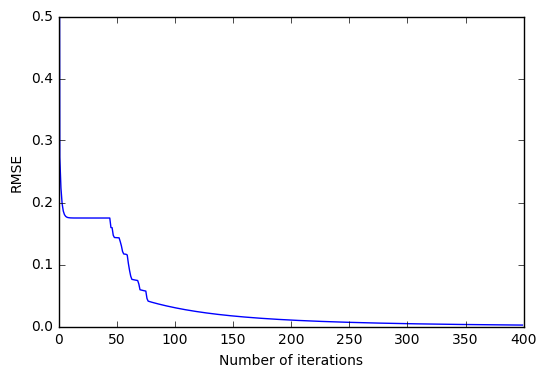

In [6]:
x_coordinate = range(len(rmse))
plt.ylim(0,0.5)
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.plot(x_coordinate,rmse,'-')

## Summary: Three ways to do SVD in python  
**The first is for normal matrix SVD using numpy.linalg;
The second and the third is specially for sparse SVD.   
There are 2 differences between the second and the third:   
1) the second's singular values are in increasing order while the third's are in descending order.  
2) The left singular vector of the seocnd is the transpose of the third one.**

In [45]:
# 1st
U,s,V = la.svd(Y.todense())
print U.shape,s.shape,V.shape
S = np.zeros(Y.shape)
index = s.shape[0]
S[:index, :index] = np.diag(s)
np.dot(U,np.dot(S,V))

(150L, 150L) (150L,) (300L, 300L)


matrix([[  1.42501751e+01,   1.51663149e-14,  -1.43129821e-14, ...,
           1.11406264e+01,   3.23330912e-15,  -1.79481094e+01],
        [  6.36886317e-14,  -5.88838748e+01,   2.36050014e-15, ...,
           7.56511574e+00,  -6.54798604e-14,   7.79347375e-15],
        [ -2.83728904e+01,   7.63808385e-14,  -3.53673644e-14, ...,
          -7.63042399e+00,  -1.53626084e+01,   2.95319404e+01],
        ..., 
        [ -1.00336550e-13,   2.79243372e+01,   1.95472423e+01, ...,
          -2.04945159e-15,  -7.12964941e-14,   2.80066460e-14],
        [  6.52392064e+01,  -4.70715735e-14,  -1.88089682e+01, ...,
           1.59887465e-15,   3.69293850e+00,   6.94302428e-15],
        [ -1.63059703e+01,  -8.67471368e-15,   5.18816562e-14, ...,
          -4.44877500e-14,  -3.21336114e-14,   5.74453511e-14]])

In [51]:
# 2nd
u1,s1,v1 = ss.linalg.svds(Y,6)
print u1.shape,s1.shape,v1.shape
print s1
(u1*s1).dot(v1)

(150L, 6L) (6L,) (6L, 300L)
[ 1077.93575303  1078.94084481  1079.86244283  1081.00099544  1082.43767384
  1602.39579244]


array([[  0.93475894,  -1.69656889,  20.39140556, ...,   1.99293127,
         -0.9501656 ,   5.13083661],
       [ 24.46087109,   0.08695084,  12.47402609, ...,   4.02753676,
         -1.77296115,   5.06209865],
       [ -4.16327272,   0.79898135,   0.13229599, ...,   3.26257497,
          1.91033556,   9.63002219],
       ..., 
       [ 18.38672915,  18.07049233,   1.31570108, ...,  10.56529213,
         11.27349825,   2.58618828],
       [ 24.47471489,   9.99896372,  -0.96920197, ...,   3.63494168,
          0.78564538,   2.57794705],
       [  6.44554284,   3.01631162,   4.47305393, ...,  13.38238602,
         12.3795926 ,   9.54896807]])

In [52]:
# 3rd
ut, s, vt = sparsesvd(ss.csc_matrix(Y),6)
print ut.shape,s.shape,vt.shape
print s
(ut.T*s).dot(vt)

(6L, 150L) (6L,) (6L, 300L)
[ 1602.39579244  1082.43767384  1081.00099544  1079.86244283  1078.94084481
  1077.93575303]


array([[  0.93475894,  -1.69656889,  20.39140556, ...,   1.99293127,
         -0.9501656 ,   5.13083661],
       [ 24.46087109,   0.08695084,  12.47402609, ...,   4.02753676,
         -1.77296115,   5.06209865],
       [ -4.16327272,   0.79898135,   0.13229599, ...,   3.26257497,
          1.91033556,   9.63002219],
       ..., 
       [ 18.38672915,  18.07049233,   1.31570108, ...,  10.56529213,
         11.27349825,   2.58618828],
       [ 24.47471489,   9.99896372,  -0.96920197, ...,   3.63494168,
          0.78564538,   2.57794705],
       [  6.44554284,   3.01631162,   4.47305393, ...,  13.38238602,
         12.3795926 ,   9.54896807]])

## Solving the Netflix Problem using SVT above

**I have done some preprocessing to the Netfilx files(e.g. mapping the users id ranging from [6,2649429] to their actual id number [1-480189]) which takes about an hour just for running the program.  
Then I wrote the rate, rates' row index and rates' col index into the following 'rate.csv', 'row.csv', 'col.csv' files And I directly read from these files to save time and write them into a sparse matrix M_original.  
The rows of M_original are the users' actual id numbers ranging from [1,480189] while the columns are the id of 17770 movies. The data in the matrix is the rates. 
**

In [3]:
start = time.clock()

row = pd.read_csv('G:/nf_prize_dataset/download/row.csv',header = None).iloc[:,1]
col = pd.read_csv('G:/nf_prize_dataset/download/col.csv',header = None).iloc[:,1]
rate = pd.read_csv('G:/nf_prize_dataset/download/rate.csv',header = None).iloc[:,1]

M_original = ss.csr_matrix((rate,(row,col)),shape = (480189,17770))

time.clock() - start

125.623319606266

In [11]:
def SVT(M1,iter_num):
    
    n1,n2 = M1.shape
    total_num = len(M1.nonzero()[0])
    proportion = 1.0
    idx = random.sample(range(total_num),int(total_num*proportion))
    Omega = (M1.nonzero()[0][idx],M1.nonzero()[1][idx])
    p = 0.5
    tau=20000
    delta = 2
    maxiter = iter_num
    tol = 0.001
    incre = 5

    # SVT
    r = 0
    b = M1[Omega]
    #P_Omega_M = ss.csr_matrix((np.ravel(M1[Omega]),Omega),shape = (n1,n2))
    P_Omega_M = ss.csr_matrix((np.ravel(b),Omega),shape = (n1,n2))
    #P_Omega_M = M1[Omega]
    normProjM = norm(P_Omega_M)
    k0 = np.ceil(tau / (delta*normProjM))
    Y = k0*delta*P_Omega_M
    rmse = []

    for k in xrange(maxiter):
        #print str(k+1) + ' iterative.'
        s = r + 1
        while True:
            u1,s1,v1 = sparsesvd(ss.csc_matrix(Y),s)
            if s1[s-1] <= tau : break
            s = min(s+incre,n1,n2)
            if s == min(n1,n2): break

        r = np.sum(s1>tau)
        U = u1.T[:,:r]
        V = v1[:r,:]
        S = s1[:r]-tau
        x = (U*S).dot(V)
        x_omega = ss.csr_matrix((x[Omega],Omega),shape = (n1,n2))                                      

        if norm(x_omega-P_Omega_M)/norm(P_Omega_M) < tol:
            break

        diff = P_Omega_M-x_omega
        Y += delta*diff
        #rmse.append(norm(diff)/np.sqrt(n1*n2))
        rmse.append(la.norm(M1[M1.nonzero()]-x[M1.nonzero()]) / np.sqrt(len(x[M1.nonzero()])))

    return rmse

### 1. # of iteration increases (# of entries fixed = 1000) 
### 50,100,150,200 iterations are picked

In [16]:
start = time.clock()
num_of_entries = 1000
M1 = M_original[:num_of_entries]
iter_list = range(50,250,50)
rmse1 = []
for item in iter_list:
    rmse1.append(SVT(M1,item)[-1])
time.clock() - start

100.847874095507

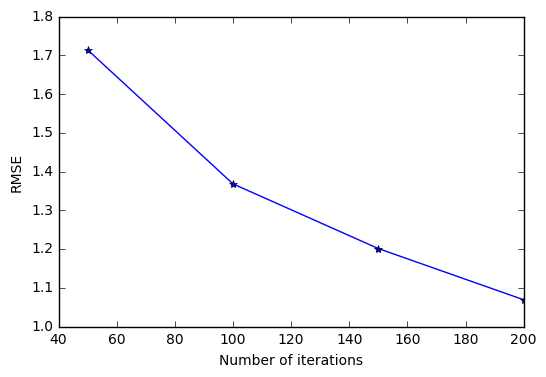

In [20]:
plt.plot(iter_list,rmse1,'*-')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')

### 2. # of entries increases (# of iteration fixed = 50)  
### the first 1000,5000,10000, 20000 entries are picked

In [21]:
start = time.clock()
entry_list = [1000,5000,10000,20000]
num_of_iter = 50
rmse2 = []
for entry in entry_list:
    M2 = M_original[:entry]
    rmse2.append(SVT(M2,num_of_iter)[-1])
time.clock() - start

481.6677343859876

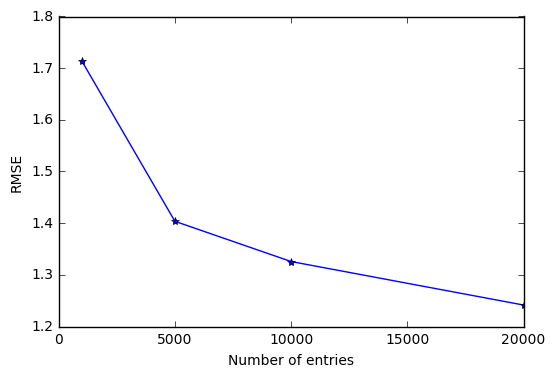

In [22]:
plt.plot(entry_list,rmse2,'*-')
plt.xlabel('Number of entries')
plt.ylabel('RMSE')

In [23]:
prize = SVT(M1,500)[-1]
print 'RMSE of the first 1000 entries after 500 iterations is ' + str(prize)

RMSE of the first 1000 entries after 500 iterations is 0.503782833808


### The first 30 nonzero positions in original matrix and corresponding positions in the recovered matrix

In [178]:
np.ravel(M1[M1.nonzero()])[:30]

array([4, 1, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3,
       3, 5, 4, 3, 4, 4, 4], dtype=int64)

In [179]:
x[M1.nonzero()][:30]

array([ 4.49254372,  3.41037303,  3.3753717 ,  3.67593247,  3.96947469,
        3.11330046,  2.93233882,  3.91806753,  3.44414921,  3.17645675,
        3.4369803 ,  2.82602535,  0.59842739,  3.10117755,  2.48876949,
        3.47967146,  3.88680603,  2.76881792,  2.93507081,  3.17284492,
        3.00022459,  4.07358373,  2.50363419,  3.26932372,  3.40469312,
        3.50418383,  2.74553892,  3.50834477,  3.24846476,  4.01094857])

In [112]:
haha = np.round(x[M1.nonzero()])

In [116]:
np.sum(haha == np.ravel(M1[M1.nonzero()]))/len(haha)

0.78295943687648761

In [124]:
# the last 10 rmse of the first 1000 entries after 500 iterations
rmse[-10:]

[0.51488720935406096,
 0.51362005690728341,
 0.51208922196564666,
 0.51076399386771054,
 0.50965240559823977,
 0.50861479136851773,
 0.507082230565296,
 0.5058643580998945,
 0.50479622069681851,
 0.50378283380813227]